<a href="https://colab.research.google.com/github/JaydenGraves/NFL-prediction-model/blob/main/nfl_game_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.listdir('/content')


['.config', 'sample_data']

In [6]:
import pandas as pd

df = pd.read_csv("spreadspoke_scores.csv")
df.head()


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


In [7]:
df["home_win"] = (df["score_home"] > df["score_away"]).astype(int)
df[["team_home", "team_away", "score_home", "score_away", "home_win"]].head()


,team_home,team_away,score_home,score_away,home_win
0,Miami Dolphins,Oakland Raiders,14.0,23.0,0
1,Houston Oilers,Denver Broncos,45.0,7.0,1
2,San Diego Chargers,Buffalo Bills,27.0,7.0,1
3,Miami Dolphins,New York Jets,14.0,19.0,0
4,Green Bay Packers,Baltimore Colts,24.0,3.0,1


In [52]:
model_df = df[["team_home", "team_away", "score_home", "score_away", "home_win",
               "team_favorite_id","spread_favorite","over_under_line", "schedule_season", "schedule_week"]].dropna()
model_df.head()

,team_home,team_away,score_home,score_away,home_win,team_favorite_id,spread_favorite,over_under_line,schedule_season,schedule_week
350,Green Bay Packers,Oakland Raiders,33.0,14.0,1,GB,-13.5,43,1967,Superbowl
538,Baltimore Colts,New York Jets,7.0,16.0,0,IND,-18.0,40,1968,Superbowl
727,Kansas City Chiefs,Minnesota Vikings,23.0,7.0,1,MIN,-12.0,39,1969,Superbowl
916,Baltimore Colts,Dallas Cowboys,16.0,13.0,1,IND,-2.5,36,1970,Superbowl
1105,Dallas Cowboys,Miami Dolphins,24.0,3.0,1,DAL,-6.0,34,1971,Superbowl


In [54]:
import numpy as np

# Convert the numeric columns to actual numeric values first
model_df["spread_favorite"] = pd.to_numeric(model_df["spread_favorite"], errors="coerce")
model_df["over_under_line"] = pd.to_numeric(model_df["over_under_line"], errors="coerce")

# 1 = home team was favored, 0 = they were the underdog
model_df["is_home_fav"] = (model_df["team_favorite_id"] == model_df["team_home"]).astype(int)

# Convert spread so the number helps the model:
# If home is favored, spread becomes negative (example -3.5 means home should win by 3.5)
model_df["home_spread"] = np.where(
 model_df["is_home_fav"] == 1,
  -model_df["spread_favorite"],
  model_df["spread_favorite"])

#These are the inputs (x) and the answer we want to predict is (y)
features = ["home_spread", "over_under_line", "is_home_fav"]
x = model_df[features].dropna() # Add dropna() here to remove any rows with NaNs introduced by pd.to_numeric
y = model_df.loc[x.index, "home_win"] # Ensure y aligns with x after dropping NaNs

In [20]:
# The numeric conversions and feature engineering are now handled in the previous cell.
# Recreate X and y based on the already cleaned and processed model_df

features = ["home_spread", "over_under_line", "is_home_fav"]
X = model_df[features].dropna()
y = model_df.loc[X.index, "home_win"]

X.head()

,home_spread,over_under_line,is_home_fav
350,-13.5,43.0,0
538,-18.0,40.0,0
727,-12.0,39.0,0
916,-2.5,36.0,0
1105,-6.0,34.0,0


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Split games into training and testing sections
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Make the model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Test how accurate the model is
predicitions = model.predict(X_test)
accuracy = accuracy_score(y_test, predicitions)

accuracy


0.5531276778063411

In [22]:
# Make a copy so we dont break anything
games = df.copy()

#First, calculate home and away points as seperate columns
games["home_points_for"] = games["score_home"]
games["home_points_against"] = games["score_away"]

games["away_points_for"] = games["score_away"]
games["away_points_against"] = games["score_home"]

In [23]:
# Calculate average points scored and allowed per season for each team (home + away)
home_stats = games.groupby(["team_home", "schedule_season"]).agg(
    avg_home_points_for=("home_points_for", "mean"),
    avg_home_points_against=("home_points_against", "mean")
).reset_index().rename(columns={"team_home": "team"})

away_stats = games.groupby(["team_away", "schedule_season"]).agg(
    avg_away_points_for=("away_points_for", "mean"),
    avg_away_points_against=("away_points_against", "mean")
).reset_index().rename(columns={"team_away": "team"})

# Merge both to create overall season averages
team_stats = pd.merge(home_stats, away_stats, on=["team", "schedule_season"], how="inner")

team_stats["avg_points_for"] = (team_stats["avg_home_points_for"] + team_stats["avg_away_points_for"]) / 2
team_stats["avg_points_against"] = (team_stats["avg_home_points_against"] + team_stats["avg_away_points_against"]) / 2

team_stats.head()


,team,schedule_season,avg_home_points_for,avg_home_points_against,avg_away_points_for,avg_away_points_against,avg_points_for,avg_points_against
0,Arizona Cardinals,1994,18.500,14.875,10.875,18.500,14.6875,16.6875
1,Arizona Cardinals,1995,18.625,25.375,15.750,27.375,17.1875,26.3750
2,Arizona Cardinals,1996,21.875,24.375,15.625,25.250,18.7500,24.8125
3,Arizona Cardinals,1997,22.375,27.625,13.000,19.750,17.6875,23.6875
4,Arizona Cardinals,1998,21.000,18.500,19.800,27.800,20.4000,23.1500


In [55]:
# Merge team stats onto the main model data (for both home and away teams)
model = model_df.copy()

model = model.merge(team_stats[["team", "schedule_season", "avg_points_for", "avg_points_against"]],
                    left_on=["team_home", "schedule_season"], right_on=["team", "schedule_season"], how="left")
model = model.rename(columns={
    "avg_points_for": "home_avg_points_for",
    "avg_points_against": "home_avg_points_against"
}).drop(columns=["team"])

model = model.merge(team_stats[["team", "schedule_season", "avg_points_for", "avg_points_against"]],
                    left_on=["team_away", "schedule_season"], right_on=["team", "schedule_season"], how="left")
model = model.rename(columns={
    "avg_points_for": "away_avg_points_for",
    "avg_points_against": "away_avg_points_against"
}).drop(columns=["team"])

model.head()

,team_home,team_away,score_home,score_away,home_win,team_favorite_id,spread_favorite,over_under_line,schedule_season,schedule_week,is_home_fav,home_spread,home_avg_points_for,home_avg_points_against,away_avg_points_for,away_avg_points_against
0,Green Bay Packers,Oakland Raiders,33.0,14.0,1,GB,-13.5,43.0,1967,Superbowl,0,-13.5,24.707143,15.371429,32.625000,17.062500
1,Baltimore Colts,New York Jets,7.0,16.0,0,IND,-18.0,40.0,1968,Superbowl,0,-18.0,27.625000,10.208333,28.875000,19.375000
2,Kansas City Chiefs,Minnesota Vikings,23.0,7.0,1,MIN,-12.0,39.0,1969,Superbowl,0,-12.0,24.347222,11.673611,25.243056,10.770833
3,Baltimore Colts,Dallas Cowboys,16.0,13.0,1,IND,-2.5,36.0,1970,Superbowl,0,-2.5,21.900000,15.771429,19.729167,14.263889
4,Dallas Cowboys,Miami Dolphins,24.0,3.0,1,DAL,-6.0,34.0,1971,Superbowl,0,-6.0,27.270833,14.236111,21.777778,12.756944


In [41]:
features = ["home_spread", "over_under_line", "is_home_fav",
            "home_avg_points_for", "home_avg_points_against",
            "away_avg_points_for", "away_avg_points_against"]
X = model[features].dropna() # Drop rows with NaN values
y = model.loc[X.index, "home_win"] # Align y with the cleaned X

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

model2 = LogisticRegression(max_iter=3000)
model2.fit(X_train, Y_train)

predicitions = model2.predict(X_test)
accuracy = accuracy_score(Y_test, predicitions)

accuracy

0.6975149957155099

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Baseline: predict home win if home was the Vegas favorite
# Align baseline_pred with the same indices as Y_test
baseline_pred = model.loc[Y_test.index, "is_home_fav"].values
baseline_acc  = accuracy_score(Y_test, baseline_pred)

print(f"Model accuracy:   {accuracy:.3f}")
print(f"Baseline (favorite) accuracy: {baseline_acc:.3f}")

Model accuracy:   0.698
Baseline (favorite) accuracy: 0.454


In [46]:
import pandas as pd
coef = pd.DataFrame({"feature": X.columns, "coef": model2.coef_[0]}).sort_values("coef", ascending=False)
coef

,feature,coef
3,home_avg_points_for,0.145086
6,away_avg_points_against,0.143698
0,home_spread,0.005549
2,is_home_fav,0.000000
1,over_under_line,-0.010181
5,away_avg_points_for,-0.118812
4,home_avg_points_against,-0.148611


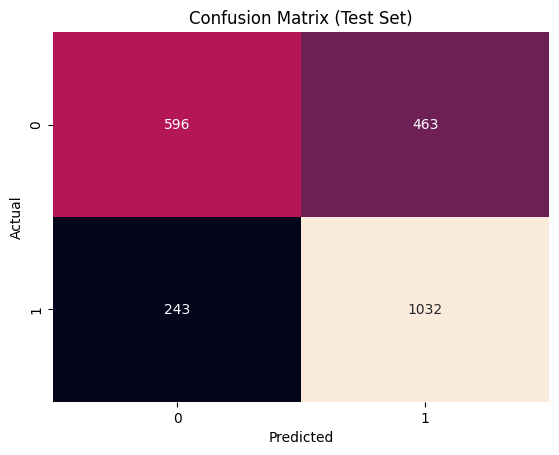

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, predicitions)
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix (Test Set)")
plt.show()

/tmp/ipython-input-1694664591.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = pd.DataFrame({"prob": probs, "actual": y_test}).groupby(bins).mean().reset_index(drop=True)


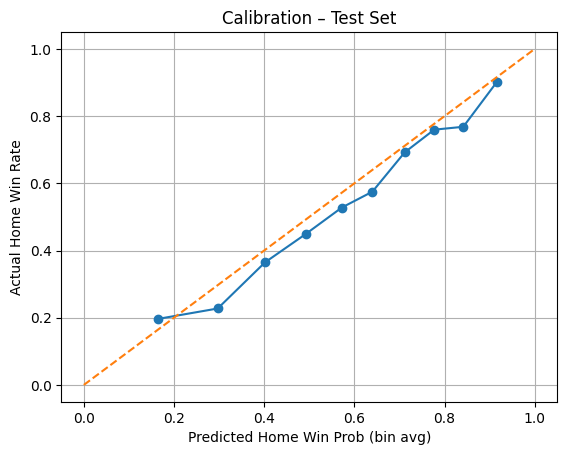

In [49]:
probs = model2.predict_proba(X_test)[:,1]
bins = pd.qcut(probs, q=10, duplicates='drop')
cal = pd.DataFrame({"prob": probs, "actual": y_test}).groupby(bins).mean().reset_index(drop=True)

plt.plot(cal["prob"], cal["actual"], marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted Home Win Prob (bin avg)")
plt.ylabel("Actual Home Win Rate")
plt.title("Calibration – Test Set")
plt.grid(True); plt.show()


In [57]:
out = model.loc[Y_test.index, ["schedule_season", "schedule_week", "team_home", "team_away"]].copy()
out["pred_home_win_prob"] = probs
out["actual_home_win"] = (probs >= 0.5).astype(int)
out["actual_home_win"] = Y_test.values # Use Y_test here for consistency
out.head(10)

,schedule_season,schedule_week,team_home,team_away,pred_home_win_prob,actual_home_win
9398,2017,1,San Francisco 49ers,Carolina Panthers,0.407156,0
9399,2017,1,Tennessee Titans,Oakland Raiders,0.658602,0
9400,2017,1,Washington Redskins,Philadelphia Eagles,0.199746,0
9401,2017,1,Denver Broncos,Los Angeles Chargers,0.234411,1
9402,2017,1,Minnesota Vikings,New Orleans Saints,0.596191,1
9403,2017,2,Cincinnati Bengals,Houston Texans,0.683629,0
9404,2017,2,Atlanta Falcons,Green Bay Packers,0.800824,1
9405,2017,2,Baltimore Ravens,Cleveland Browns,0.934792,1
9406,2017,2,Carolina Panthers,Buffalo Bills,0.748220,1
9407,2017,2,Denver Broncos,Dallas Cowboys,0.351220,1


In [58]:
# Keep only modern era games
df = df[df["schedule_season"] >= 2015]

df.head()


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_win
11343,9/10/2015,2015,1,False,New England Patriots,28.0,21.0,Pittsburgh Steelers,NE,-7.0,51,Gillette Stadium,False,64.0,9.0,NaN,rain,1
11344,9/13/2015,2015,1,False,Arizona Cardinals,31.0,19.0,New Orleans Saints,ARI,-2.5,48.5,University of Phoenix Stadium,False,72.0,0.0,NaN,indoor,1
11345,9/13/2015,2015,1,False,Buffalo Bills,27.0,14.0,Indianapolis Colts,IND,-1.0,44.5,Ralph Wilson Stadium,False,53.0,7.0,NaN,NaN,1
11346,9/13/2015,2015,1,False,Chicago Bears,23.0,31.0,Green Bay Packers,GB,-6.5,48.5,Soldier Field,False,68.0,4.0,NaN,NaN,0
11347,9/13/2015,2015,1,False,Dallas Cowboys,27.0,26.0,New York Giants,DAL,-7.0,52.5,Cowboys Stadium,False,72.0,0.0,NaN,indoor,1


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [61]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=2000)

In [62]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
accuracy


0.6975149957155099

In [66]:
# Use only recent games
df_recent = df[df["schedule_season"] >= 2015].copy()

# Use the Vegas spread (a pre-game predictive feature)
X = df_recent[["spread_favorite"]].dropna() # Drop rows with NaN values in 'spread_favorite'

# Target: did home team win?
y = (df_recent["score_home"] > df_recent["score_away"]).astype(int)
y = y.loc[X.index] # Align y with the cleaned X

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Accuracy
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
accuracy = accuracy_score(y_test, pred)

accuracy

0.5434027777777778

In [67]:
import numpy as np
import pandas as pd

# Keep 2015+ games
df_recent = df[df["schedule_season"] >= 2015].copy()

# Make sure betting columns are numeric
df_recent["spread_favorite"] = pd.to_numeric(df_recent["spread_favorite"], errors="coerce")
df_recent["over_under_line"] = pd.to_numeric(df_recent.get("over_under_line"), errors="coerce")

# Who was the favorite?
df_recent["is_home_fav"] = (df_recent["team_favorite_id"] == df_recent["team_home"]).astype(int)

# Re-express spread from the home team's view (negative = home is favored)
df_recent["home_spread"] = np.where(df_recent["is_home_fav"]==1,
                                    -df_recent["spread_favorite"],
                                     df_recent["spread_favorite"])

# Target: did home team win?
df_recent["home_win"] = (df_recent["score_home"] > df_recent["score_away"]).astype(int)


In [68]:
games = df_recent.copy()

# Home-side tallies
home = games.groupby(["team_home","schedule_season"]).agg(
    pf_home=("score_home","mean"),
    pa_home=("score_away","mean")
).reset_index().rename(columns={"team_home":"team"})

# Away-side tallies
away = games.groupby(["team_away","schedule_season"]).agg(
    pf_away=("score_away","mean"),
    pa_away=("score_home","mean")
).reset_index().rename(columns={"team_away":"team"})

# Combine to overall season averages
team_stats = home.merge(away, on=["team","schedule_season"], how="outer").fillna(0)
team_stats["avg_points_for"] = (team_stats["pf_home"] + team_stats["pf_away"]) / 2
team_stats["avg_points_against"] = (team_stats["pa_home"] + team_stats["pa_away"]) / 2

team_stats = team_stats[["team","schedule_season","avg_points_for","avg_points_against"]]
team_stats.head()


,team,schedule_season,avg_points_for,avg_points_against
0,Arizona Cardinals,2015,29.444444,21.222222
1,Arizona Cardinals,2016,26.125000,22.625000
2,Arizona Cardinals,2017,18.437500,22.562500
3,Arizona Cardinals,2018,14.062500,26.562500
4,Arizona Cardinals,2019,22.562500,27.625000


In [69]:
# @title
model = df_recent.copy()

# Attach HOME team season strength
model = model.merge(team_stats, left_on=["team_home","schedule_season"],
                    right_on=["team","schedule_season"], how="left")
model = model.rename(columns={
    "avg_points_for":"home_avg_pf",
    "avg_points_against":"home_avg_pa"
}).drop(columns=["team"])

# Attach AWAY team season strength
model = model.merge(team_stats, left_on=["team_away","schedule_season"],
                    right_on=["team","schedule_season"], how="left")
model = model.rename(columns={
    "avg_points_for":"away_avg_pf",
    "avg_points_against":"away_avg_pa"
}).drop(columns=["team"])

# Keep rows that have everything we need
features = ["home_spread","over_under_line","is_home_fav",
            "home_avg_pf","home_avg_pa","away_avg_pf","away_avg_pa"]
model = model.dropna(subset=features + ["home_win"])


In [70]:
# @title
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = model[features]
y = model["home_win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
acc


0.7170138888888888

In [72]:
# @title
predictions_df = pd.DataFrame({
    "team_home": model.loc[X_test.index, "team_home"],
    "team_away": model.loc[X_test.index, "team_away"],
    "predicted_home_win": pred,
    "actual_result": y_test
})
predictions_df.head(10)

,team_home,team_away,predicted_home_win,actual_result
2302,Houston Texans,Tampa Bay Buccaneers,1,1
2303,Kansas City Chiefs,Miami Dolphins,1,1
2304,Las Vegas Raiders,New York Giants,1,1
2305,New England Patriots,Washington Commanders,1,0
2306,New Orleans Saints,Chicago Bears,1,1
2307,Philadelphia Eagles,Dallas Cowboys,0,1
2308,New York Jets,Los Angeles Chargers,1,0
2309,Chicago Bears,Carolina Panthers,1,1
2310,Arizona Cardinals,Atlanta Falcons,0,1
2311,Baltimore Ravens,Cleveland Browns,1,0
